In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
calib_maglim = [3974, 6699, 9962, 11139, 12460, 13163, 19871, 
                21102, 22277, 26761, 28378, 29128, 38148, 41020, 
                41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]
I_maglim = [38803, 39181, 39431, 39619, 40005, 40107, 40147, 40588,
            40604, 41567, 41829, 42768, 5807403, 5057729, 4002181, 4321374, 37814]

In [3]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

In [4]:
band = 'w1'
Clusters, slope0, zp0, slope_e0 = TF_iter(table, band = band, n_iter=5, verbose=False, pgcFaint=I_maglim)
print slope0, zp0

zp_calibs = all_ZP(table, band=band, slope=slope0, pgcFaint=calib_maglim)
slope = zp_calibs['slope']
zp    = zp_calibs['zp']
print slope0, slope_e0, slope, zp

-9.468268741542905 -0.002563244327637272
108
-9.468268741542905 0.14223316557652027 -9.468268741542905 -20.42769065471863


In [5]:
Clusters_i = allCluster(table, band='i')
key0 = 'NEST_100002'
myCluster_i = Clusters_i[key0]
logWimx_i = myCluster_i['logWimx']
pgc_i = myCluster_i['pgc']
for i, key in enumerate(Clusters_i):
    if key!=key0:
        myCluster_i = Clusters_i[key]
        pgc_i =  np.concatenate((pgc_i, myCluster_i['pgc']))

Clusters = allCluster(table, band=band, slope=slope, pgcFaint=I_maglim)
key0 = 'NEST_100002'
myCluster = Clusters[key0]
zp_virgo = myCluster['zp']
W1_mag = myCluster['mag']-zp_virgo+zp
logWimx = myCluster['logWimx']
pgc_ = myCluster['pgc']
for i, key in enumerate(Clusters):
    if key!=key0:
        myCluster = Clusters[key]
        zp_ = myCluster['zp']
        W1_mag = np.concatenate((W1_mag, myCluster['mag']-zp_+zp))
        logWimx = np.concatenate((logWimx, myCluster['logWimx']))
        pgc_ =  np.concatenate((pgc_, myCluster['pgc']))
        

indx = []
for i, idd in enumerate(pgc_):
    if not idd in I_maglim and not idd in pgc_i and W1_mag[i]>-16.5:
        indx.append(i)

if len(indx)>0:
    print pgc_[indx]
    W1_maglim = np.concatenate((I_maglim, pgc_[indx]))
    print W1_maglim

[14548 14590]
[  38803   39181   39431   39619   40005   40107   40147   40588   40604
   41567   41829   42768 5807403 5057729 4002181 4321374   37814   14548
   14590]


In [6]:
band = 'w1'
Clusters, slope0, zp0, slope_e0 = TF_iter(table, band = band, n_iter=5, verbose=False, pgcFaint=W1_maglim)
print slope0, zp0

zp_calibs = all_ZP(table, band=band, slope=slope0, pgcFaint=calib_maglim)
slope = zp_calibs['slope']
zp    = zp_calibs['zp']
zp_e = zp_calibs['zp_e']
print slope0, slope_e0, slope, zp

-9.468231637811998 -0.0025900168744938347
108
-9.468231637811998 0.14223258050410356 -9.468231637811998 -20.427689350474594


In [7]:
Clusters_i = allCluster(table, band='i')
key0 = 'NEST_100002'
myCluster_i = Clusters_i[key0]
logWimx_i = myCluster_i['logWimx']
pgc_i = myCluster_i['pgc']
for i, key in enumerate(Clusters_i):
    if key!=key0:
        myCluster_i = Clusters_i[key]
        pgc_i =  np.concatenate((pgc_i, myCluster_i['pgc']))

Clusters = allCluster(table, band=band, slope=slope, pgcFaint=I_maglim)
key0 = 'NEST_100002'
myCluster = Clusters[key0]
zp_virgo = myCluster['zp']
W1_mag = myCluster['mag']-zp_virgo+zp
logWimx = myCluster['logWimx']
pgc_ = myCluster['pgc']
for i, key in enumerate(Clusters):
    if key!=key0:
        myCluster = Clusters[key]
        zp_ = myCluster['zp']
        W1_mag = np.concatenate((W1_mag, myCluster['mag']-zp_+zp))
        logWimx = np.concatenate((logWimx, myCluster['logWimx']))
        pgc_ =  np.concatenate((pgc_, myCluster['pgc']))
        

indx = []
for i, idd in enumerate(pgc_):
    if not idd in I_maglim and not idd in pgc_i and W1_mag[i]>-16.5:
        indx.append(i)

if len(indx)>0:
    print pgc_[indx]
    W1_maglim = np.concatenate((I_maglim, pgc_[indx]))
    print W1_maglim

[14548 14590]
[  38803   39181   39431   39619   40005   40107   40147   40588   40604
   41567   41829   42768 5807403 5057729 4002181 4321374   37814   14548
   14590]


Text(1.548,-21.6,'ZP = -20.43$\\pm$0.07')

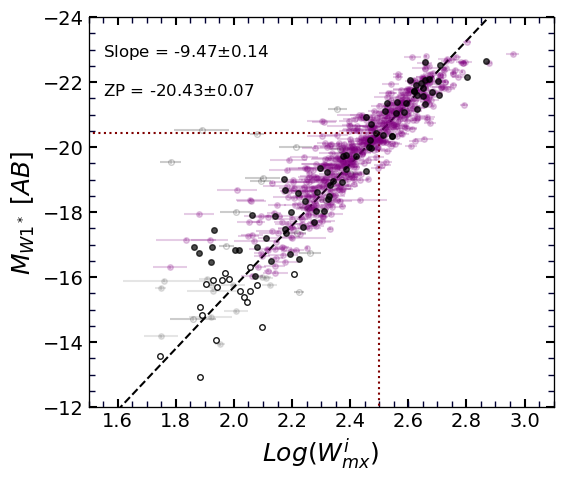

In [8]:
Clusters = allCluster(table, band=band, slope=slope, pgcFaint=W1_maglim)

dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
cmap = get_cmap(21)
fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12,-24), MAGabs=True)

key0 = 'NEST_100002'
myCluster = Clusters[key0]
zp_virgo = myCluster['zp']
I_mag = myCluster['mag']-zp_virgo+zp
logWimx = myCluster['logWimx']
pgc_ = myCluster['pgc']

for i, key in enumerate(Clusters):
    if key!=key0:
        myCluster = Clusters[key]
        zp_ = myCluster['zp']
        plotCluster(ax, Clusters, nest=key, offset=zp_-zp, plotErrors=True, 
                    alpha=0.2, markersize=0, pgcFaint=W1_maglim, plotWeird=True) # cmap(i)
        I_mag = np.concatenate((I_mag, myCluster['mag']-zp_+zp))
        logWimx = np.concatenate((logWimx, myCluster['logWimx']))
        pgc_ =  np.concatenate((pgc_, myCluster['pgc']))
    else:
        plotCluster(ax, Clusters, nest=key, offset=zp_virgo-zp, plotErrors=True, alpha=0.2, 
                    markersize=0, pgcFaint=W1_maglim, plotWeird=True)

plotCluster(ax, zp_calibs, markersize=8, plotFit=True, color='k', pgcFaint=calib_maglim)


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.97*Xlm[0]+0.03*Xlm[1]
y0 = 0.1*Ylm[0]+0.90*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % slope0+'$\pm$'+"%.2f" % slope_e0, fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.80*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % zp+'$\pm$'+"%.2f" % zp_e, fontsize=12, color='k')


In [9]:
print list(W1_maglim)


[38803, 39181, 39431, 39619, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 5807403, 5057729, 4002181, 4321374, 37814, 14548, 14590]
